In [18]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt 


In [19]:
headers = ["prev", "curr", "type", "n"]
clicks202303 = pd.read_csv("../data/clickstream-enwiki-2023-03.tsv", sep="\t", names=headers)

In [20]:
clicks202303.head(5)

,prev,curr,type,n
0,2023_Baltimore_Ravens_season,Shemar_Bridges,link,66.0
1,Indiana_Jones_and_the_Dial_of_Destiny,Avatar:_The_Way_of_Water,other,39.0
2,other-search,Shemar_Bridges,external,80.0
3,List_of_West_Bromwich_Albion_F.C._managers,Brian_Talbot,link,28.0
4,List_of_current_AFC_team_rosters,Shemar_Bridges,link,20.0


In [21]:
print(f"Length: {len(clicks202303)}")
print(f"Nulls: {clicks202303.isna().sum().sum()}")
clicks202303.info()

Length: 33391772
Nulls: 88
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33391772 entries, 0 to 33391771
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   prev    object 
 1   curr    object 
 2   type    object 
 3   n       float64
dtypes: float64(1), object(3)
memory usage: 1019.0+ MB


In [22]:
clicks202303.dropna(inplace=True)
ua_prev = clicks202303[clicks202303['curr'] == 'Russian_invasion_of_Ukraine']
ua_curr = clicks202303[clicks202303['prev'] == 'Russian_invasion_of_Ukraine']

In [23]:
print(f"ua_prev length: {len(ua_prev)}")
print(f"ua_curr length: {len(ua_curr)}")

ua_prev length: 2657
ua_curr length: 572


In [24]:
ua_curr.sort_values(by="n", axis=0, ascending=False)[:50]

,prev,curr,type,n
24427619,Russian_invasion_of_Ukraine,Timeline_of_the_Russian_invasion_of_Ukraine,link,26303.0
18702221,Russian_invasion_of_Ukraine,List_of_military_engagements_during_the_Russia...,link,13179.0
16788488,Russian_invasion_of_Ukraine,Russo-Ukrainian_War,link,8353.0
23113637,Russian_invasion_of_Ukraine,Order_of_battle_for_the_Russian_invasion_of_Uk...,link,7460.0
9481243,Russian_invasion_of_Ukraine,Casualties_of_the_Russo-Ukrainian_War,link,7336.0
31252763,Russian_invasion_of_Ukraine,Wagner_Group,link,5141.0
8086764,Russian_invasion_of_Ukraine,ICC_arrest_warrants_for_Vladimir_Putin_and_Mar...,link,4623.0
31978292,Russian_invasion_of_Ukraine,Battle_of_Bakhmut,link,4519.0
29467903,Russian_invasion_of_Ukraine,Main_Page,other,4132.0
10569448,Russian_invasion_of_Ukraine,Volodymyr_Zelenskyy,link,3974.0


In [25]:
ua_prev.describe()

,n
count,2657.000000
mean,472.970267
std,9173.930777
min,10.000000
25%,15.000000
50%,25.000000
75%,65.000000
max,328720.000000


In [26]:
# Gaza–Israel conflict
# Russian invasion of Ukraine
# 2017 - 2023: clickstream prev and curr

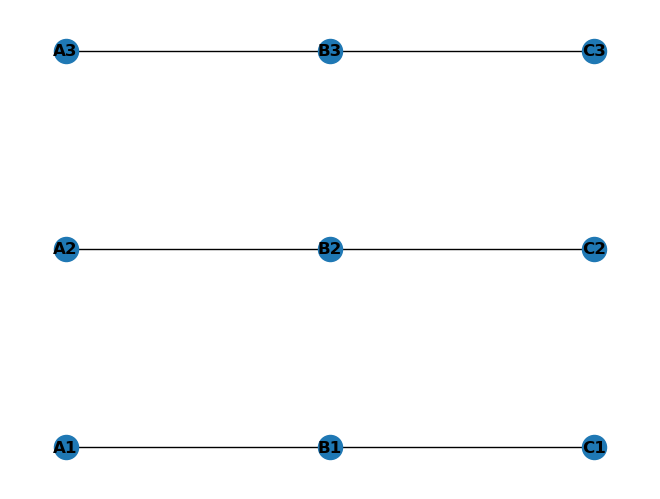

In [27]:

# Create a tripartite graph
G = nx.Graph()
G.add_nodes_from(['A1', 'A2', 'A3'], bipartite=0)  # First partition
G.add_nodes_from(['B1', 'B2', 'B3'], bipartite=1)  # Second partition
G.add_nodes_from(['C1', 'C2', 'C3'], bipartite=2)  # Third partition
G.add_edges_from([('A1', 'B1'), ('A2', 'B2'), ('A3', 'B3')])
G.add_edges_from([('B1', 'C1'), ('B2', 'C2'), ('B3', 'C3')])

# Use bipartite layout for the first two partitions
pos = {node: (0, i) for i, node in enumerate(['A1', 'A2', 'A3'])}
pos.update({node: (1, i) for i, node in enumerate(['B1', 'B2', 'B3'])})
pos.update({node: (2, i) for i, node in enumerate(['C1', 'C2', 'C3'])})

# Draw the tripartite graph
nx.draw(G, pos, with_labels=True, font_weight='bold')
plt.show()